# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from torch import zeros

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset

The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.4
valid_frac = 0.0
test_frac = 0.0
early_stop_frac = 0.4
batch_size = 74
use_LR = False # True if you want to use the LR model, False if you want to use the GRUD model

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac ,
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac,
                                                                            use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/GRUD_data/dataset.pkl


In [4]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices,
                                                            validation_indices,
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [12]:
optimized_hyperparams ={
    "hidden_size": 27,
    "learning_rate": 0.000289,
    "num_epochs":40,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 2,
    "batch_size": 74,
    "seed": 6286,
    "min_delta": 0.00001,
    }

n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": n_features,
    "X_mean": X_mean,
    "output_last": False,
    "bn_flag": True,
}

In [19]:
from utils.model_GRUD import *

# Initialize the model with filtered parameters
model = GRUD(**model_params)

# Train the model with Train_Model function
train_losses, test_losses , train_acc, test_acc = gru_trained_model_and_metadata(model,
                                                                                train_loader,
                                                                                early_stop_loader,
                                                                                epochs = optimized_hyperparams["num_epochs"],
                                                                                patience_early_stopping = optimized_hyperparams["patience_early_stopping"],
                                                                                patience_lr= optimized_hyperparams["patience_lr_scheduler"],
                                                                                min_delta = optimized_hyperparams["min_delta"],
                                                                                learning_rate = optimized_hyperparams["learning_rate"])

Model Structure:  GRUD(
  (zl): Linear(in_features=235, out_features=27, bias=True)
  (rl): Linear(in_features=235, out_features=27, bias=True)
  (hl): Linear(in_features=235, out_features=27, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=27, bias=True)
  (fc): Linear(in_features=27, out_features=1, bias=True)
  (drop): Dropout(p=0.57, inplace=False)
  (bn): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Start Training ... 
Output type dermined by the model


Training Progress:   2%|▎         | 1/40 [00:07<04:55,  7.57s/it]

Epoch 0: Validation loss improved to 0.6170
Learning Rate: 0.000500000000
Epoch: 0, train_loss: 0.66568501, valid_loss: 0.61697723


Training Progress:   5%|▌         | 2/40 [00:15<04:48,  7.58s/it]

Epoch 1: Validation loss improved to 0.6072
Learning Rate: 0.000500000000
Epoch: 1, train_loss: 0.62216095, valid_loss: 0.60724866


Training Progress:   8%|▊         | 3/40 [00:22<04:40,  7.59s/it]

Epoch 2: Validation loss improved to 0.6050
Learning Rate: 0.000500000000
Epoch: 2, train_loss: 0.61024459, valid_loss: 0.60502248


Training Progress:  10%|█         | 4/40 [00:30<04:33,  7.60s/it]

Epoch 3: No improvement. Patience counter: 1/20
Learning Rate: 0.000500000000
Epoch: 3, train_loss: 0.59753617, valid_loss: 0.60579373


Training Progress:  12%|█▎        | 5/40 [00:37<04:25,  7.60s/it]

Epoch 4: No improvement. Patience counter: 2/20
Learning Rate: 0.000500000000
Epoch: 4, train_loss: 0.59096485, valid_loss: 0.60598142


Training Progress:  15%|█▌        | 6/40 [00:45<04:18,  7.61s/it]

Epoch 5: No improvement. Patience counter: 3/20
Learning Rate: 0.000100000000
Epoch: 5, train_loss: 0.58535103, valid_loss: 0.60800559


Training Progress:  18%|█▊        | 7/40 [00:53<04:10,  7.60s/it]

Epoch 6: No improvement. Patience counter: 4/20
Learning Rate: 0.000100000000
Epoch: 6, train_loss: 0.57448066, valid_loss: 0.6082431


Training Progress:  20%|██        | 8/40 [01:00<04:02,  7.57s/it]

Epoch 7: No improvement. Patience counter: 5/20
Learning Rate: 0.000100000000
Epoch: 7, train_loss: 0.57543729, valid_loss: 0.60909711


Training Progress:  22%|██▎       | 9/40 [01:08<03:54,  7.57s/it]

Epoch 8: No improvement. Patience counter: 6/20
Learning Rate: 0.000020000000
Epoch: 8, train_loss: 0.57180455, valid_loss: 0.60942231


Training Progress:  25%|██▌       | 10/40 [01:15<03:47,  7.57s/it]

Epoch 9: No improvement. Patience counter: 7/20
Learning Rate: 0.000020000000
Epoch: 9, train_loss: 0.56852016, valid_loss: 0.60966239


Training Progress:  28%|██▊       | 11/40 [01:23<03:39,  7.57s/it]

Epoch 10: No improvement. Patience counter: 8/20
Learning Rate: 0.000020000000
Epoch: 10, train_loss: 0.56626237, valid_loss: 0.60988514


Training Progress:  30%|███       | 12/40 [01:31<03:32,  7.58s/it]

Epoch 11: No improvement. Patience counter: 9/20
Learning Rate: 0.000004000000
Epoch: 11, train_loss: 0.5678158, valid_loss: 0.61012136


Training Progress:  32%|███▎      | 13/40 [01:38<03:25,  7.60s/it]

Epoch 12: No improvement. Patience counter: 10/20
Learning Rate: 0.000004000000
Epoch: 12, train_loss: 0.56695123, valid_loss: 0.6103528


Training Progress:  35%|███▌      | 14/40 [01:46<03:17,  7.60s/it]

Epoch 13: No improvement. Patience counter: 11/20
Learning Rate: 0.000004000000
Epoch: 13, train_loss: 0.56707922, valid_loss: 0.61018833


Training Progress:  38%|███▊      | 15/40 [01:53<03:10,  7.60s/it]

Epoch 14: No improvement. Patience counter: 12/20
Learning Rate: 0.000000800000
Epoch: 14, train_loss: 0.56858891, valid_loss: 0.61014672


Training Progress:  40%|████      | 16/40 [02:01<03:02,  7.60s/it]

Epoch 15: No improvement. Patience counter: 13/20
Learning Rate: 0.000000800000
Epoch: 15, train_loss: 0.56836521, valid_loss: 0.6104188


Training Progress:  42%|████▎     | 17/40 [02:09<02:54,  7.61s/it]

Epoch 16: No improvement. Patience counter: 14/20
Learning Rate: 0.000000800000
Epoch: 16, train_loss: 0.56521655, valid_loss: 0.61037337


Training Progress:  45%|████▌     | 18/40 [02:16<02:47,  7.61s/it]

Epoch 17: No improvement. Patience counter: 15/20
Learning Rate: 0.000000160000
Epoch: 17, train_loss: 0.56727529, valid_loss: 0.61048447


Training Progress:  48%|████▊     | 19/40 [02:24<02:39,  7.60s/it]

Epoch 18: No improvement. Patience counter: 16/20
Learning Rate: 0.000000160000
Epoch: 18, train_loss: 0.56342928, valid_loss: 0.61047582


Training Progress:  50%|█████     | 20/40 [02:31<02:31,  7.60s/it]

Epoch 19: No improvement. Patience counter: 17/20
Learning Rate: 0.000000160000
Epoch: 19, train_loss: 0.56725087, valid_loss: 0.61025575


Training Progress:  52%|█████▎    | 21/40 [02:39<02:24,  7.59s/it]

Epoch 20: No improvement. Patience counter: 18/20
Learning Rate: 0.000000032000
Epoch: 20, train_loss: 0.56584607, valid_loss: 0.60992152


Training Progress:  55%|█████▌    | 22/40 [02:47<02:16,  7.60s/it]

Epoch 21: No improvement. Patience counter: 19/20
Learning Rate: 0.000000032000
Epoch: 21, train_loss: 0.56740236, valid_loss: 0.61015708


Training Progress:  55%|█████▌    | 22/40 [02:54<02:22,  7.94s/it]

Epoch 22: No improvement. Patience counter: 20/20
Early stopping at epoch 22. Best validation loss: 0.6050


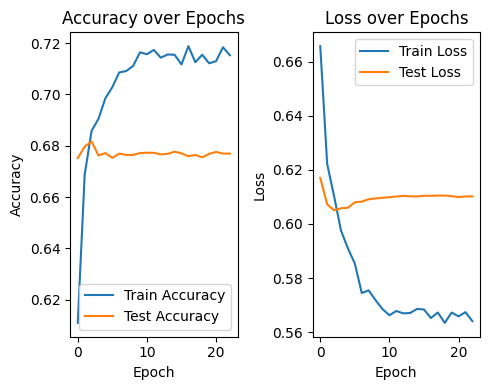

In [20]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  module_path: "utils/model_GRUD.py" 
  model_class: "GRUD"
  target_folder: "./target_GRUD"
  data_path: "./data/GRUD_data/dataset.pkl"
  ```

In [16]:
from mimic_GRUD_handler import MimicInputHandlerGRU

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRU, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

2025-02-18 10:43:44,323 INFO     Target model blueprint created from GRUD in utils/model_GRUD.py.
2025-02-18 10:43:44,330 INFO     Loaded target model metadata from ./target_GRUD/model_metadata.pkl
2025-02-18 10:43:44,333 INFO     Loaded target model from ./target_GRUD
2025-02-18 10:43:45,190 INFO     Loaded population dataset from ./data/GRUD_data/dataset.pkl
2025-02-18 10:43:45,191 INFO     Loaded population dataset from ./data/GRUD_data/dataset.pkl
2025-02-18 10:43:45,191 INFO     MIA attack factory loaded.
2025-02-18 10:43:45,191 INFO     Configuring RMIA attack
2025-02-18 10:43:45,192 INFO     Added attack: rmia
2025-02-18 10:43:45,192 INFO     Preparing attack: rmia
2025-02-18 10:43:45,193 INFO     Preparing shadow models for RMIA attack
2025-02-18 10:43:45,193 INFO     Preparing attack data for training the RMIA attack
2025-02-18 10:43:45,194 INFO     Check for 8 shadow models (dataset: 23944 points)
2025-02-18 10:43:45,195 WARNING  Using the same model class for shadow models a

## Report Genrating

In [17]:

# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

2025-02-18 10:45:33,356 INFO     Initializing report handler...
2025-02-18 10:45:33,357 INFO     report_dir set to: ./leakpro_output/results
2025-02-18 10:45:33,358 INFO     Saving results for rmia


<Figure size 640x480 with 0 Axes>

In [18]:

# # Create the report by compiling the latex text
report_handler.create_report()

2025-02-18 10:45:43,301 INFO     No results of type GIAResults found.
2025-02-18 10:45:43,302 INFO     No results of type SinglingOutResults found.
2025-02-18 10:45:43,302 INFO     No results of type InferenceResults found.
2025-02-18 10:45:43,303 INFO     No results of type LinkabilityResults found.
2025-02-18 10:45:48,543 INFO     PDF compiled


<Figure size 640x480 with 0 Axes>